# STTILL WORKING ON THE MODEL 
# STILL UPDATING 

In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, RepeatVector, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping
import joblib


In [9]:


train_df = pd.read_csv(r'C:\Users\MSI\Videos\Downloads\archive\CICIOT23\train\train.csv')
test_df = pd.read_csv(r'C:\Users\MSI\Videos\Downloads\archive\CICIOT23\test\test.csv')
val_df = pd.read_csv(r'C:\Users\MSI\Videos\Downloads\archive\CICIOT23\validation\validation.csv')

# Print shapes
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)
print("Validation shape:", val_df.shape)



Train shape: (5491971, 47)
Test shape: (1176851, 47)
Validation shape: (1176851, 47)


In [10]:
train_normal = train_df[train_df['label'] == "BenignTraffic"].copy()
val_normal   = val_df[val_df['label'] == "BenignTraffic"].copy()


In [11]:
numeric_features = train_normal.select_dtypes(include=[np.number]).columns.tolist()

print("Number of numeric features:", len(numeric_features))


Number of numeric features: 46


In [12]:
scaler = MinMaxScaler()
scaler.fit(train_normal[numeric_features])

X_train = scaler.transform(train_normal[numeric_features])
X_val   = scaler.transform(val_normal[numeric_features])
X_test  = scaler.transform(test_df[numeric_features])


In [13]:
timesteps = X_train.shape[1]
n_features = 1 # Each of the 46 values is treated as a single feature over 46 timesteps

# Reshape data to be 3D [samples, timesteps, features]
X_train = X_train.reshape(X_train.shape[0], timesteps, n_features)
X_val = X_val.reshape(X_val.shape[0], timesteps, n_features)
X_test = X_test.reshape(X_test.shape[0], timesteps, n_features)

model = Sequential([
    LSTM(64, activation='tanh', input_shape=(timesteps, n_features), return_sequences=False),
    Dropout(0.2),
    RepeatVector(timesteps),
    LSTM(64, activation='tanh', return_sequences=True),
    Dropout(0.2),
    TimeDistributed(Dense(n_features))
])

model.compile(optimizer='adam', loss='mse')
model.summary()

c:\Users\MSI\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_1 (RepeatVector)  │ (None, 46, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 46, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 46, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 46, 1)          │            65 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,985 (195.25 KB)

 Trainable params: 49,985 (195.25 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
es = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

history = model.fit(
    X_train, X_train,
    epochs=15,
    batch_size=512,
    validation_data=(X_val, X_val),
    callbacks=[es],
    verbose=2
)


Epoch 1/15
254/254 - 44s - 173ms/step - loss: 0.1185 - val_loss: 0.1146
Epoch 2/15
254/254 - 37s - 145ms/step - loss: 0.1159 - val_loss: 0.1132
Epoch 3/15
254/254 - 37s - 145ms/step - loss: 0.1146 - val_loss: 0.1176
Epoch 4/15
254/254 - 39s - 155ms/step - loss: 0.1094 - val_loss: 0.1147
Epoch 5/15
254/254 - 39s - 152ms/step - loss: 0.0875 - val_loss: 0.0559
Epoch 6/15
254/254 - 39s - 152ms/step - loss: 0.0599 - val_loss: 0.0429
Epoch 7/15
254/254 - 37s - 147ms/step - loss: 0.0396 - val_loss: 0.0225
Epoch 8/15
254/254 - 37s - 144ms/step - loss: 0.0206 - val_loss: 0.0125
Epoch 9/15
254/254 - 37s - 144ms/step - loss: 0.0147 - val_loss: 0.0114
Epoch 10/15
254/254 - 39s - 152ms/step - loss: 0.0129 - val_loss: 0.0102
Epoch 11/15
254/254 - 39s - 152ms/step - loss: 0.0118 - val_loss: 0.0076
Epoch 12/15
254/254 - 37s - 147ms/step - loss: 0.0109 - val_loss: 0.0069
Epoch 13/15
254/254 - 37s - 146ms/step - loss: 0.0102 - val_loss: 0.0200
Epoch 14/15
254/254 - 37s - 147ms/step - loss: 0.0428 - val_

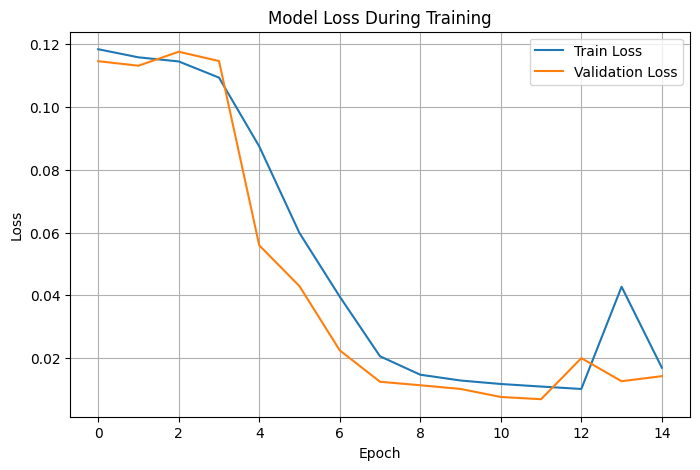

In [15]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [16]:
val_pred = model.predict(X_val, batch_size=1024)
val_mae  = np.mean(np.abs(val_pred - X_val), axis=(1,2))

threshold = np.percentile(val_mae, 95)  # Top 5% errors considered anomalies
print("Threshold:", threshold)


27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step
Threshold: 0.06904182812282385


In [17]:
test_pred = model.predict(X_test, batch_size=1024)
test_mae  = np.mean(np.abs(test_pred - X_test), axis=(1,2))


1150/1150 ━━━━━━━━━━━━━━━━━━━━ 81s 70ms/step


In [18]:
y_test = (test_df['label'] != "BenignTraffic").astype(int).values


In [19]:
y_pred = (test_mae > threshold).astype(int)


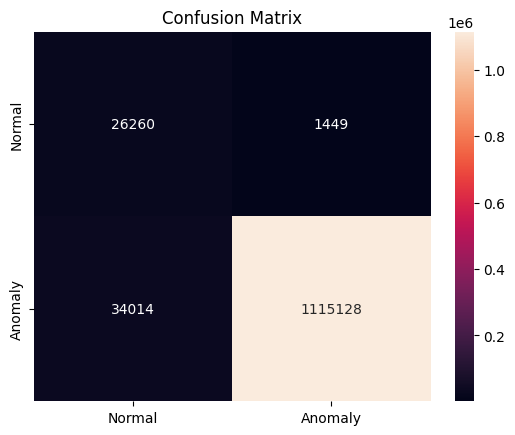

              precision    recall  f1-score   support

      Normal       0.44      0.95      0.60     27709
     Anomaly       1.00      0.97      0.98   1149142

    accuracy                           0.97   1176851
   macro avg       0.72      0.96      0.79   1176851
weighted avg       0.99      0.97      0.98   1176851



In [20]:
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=["Normal","Anomaly"],
            yticklabels=["Normal","Anomaly"])
plt.title("Confusion Matrix")
plt.show()

print(classification_report(y_test, y_pred, target_names=["Normal","Anomaly"]))


In [21]:
# Save the model 
# Save model in H5 format
model.save("lstm_autoencoder.h5")
print("Model saved as lstm_autoencoder.h5")


Model saved as lstm_autoencoder.h5


In [22]:
joblib.dump(scaler, "scaler.pkl")
print("Scaler saved successfully!")


Scaler saved successfully!


In [23]:
import json
with open("numeric_features.json", "w") as f:
    json.dump(numeric_features, f)


In [24]:
with open("threshold.json", "w") as f:
    json.dump({"threshold": float(threshold)}, f)
